## Reference Model

In [1]:
import py0
import maxent
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
# disabling gpu for now
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
M = 4
R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = R / np.sum(R, axis=1).reshape(M,1)
R, np.sum(R, axis=1)

(array([[0.08919319, 0.17202064, 0.40442023, 0.33436594],
        [0.51208724, 0.11768022, 0.14116666, 0.22906588],
        [0.35583991, 0.34303485, 0.25211881, 0.04900643],
        [0.21367089, 0.13735367, 0.23475318, 0.41422226]]),
 array([1., 1., 1., 1.]))

In [3]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = py0.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'A', 7, 0)
tmat.add_transition('A', 'I', 3, 0)
tmat.add_transition('I', 'R', 14, 0)

In [4]:
start = np.zeros((M, C))
start[0, 0] = 0.1

In [5]:
infect = py0.contact_infection_func(infections_compartments)
model = py0.MetaModel(infect, 250)

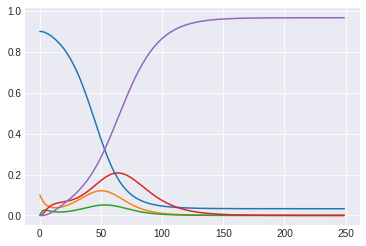

In [6]:
beta = np.array([0.02, 0.02])
ref_traj = model(R, tmat.value, start, beta)[0]
plt.plot(ref_traj[:,0])

## Sample SEIR Trajectories 

Use different compartment dist

In [7]:
# compartment parameters
compartments = ['E', 'I', 'R']
infections_compartments = [1]
C = len(compartments)
tmat = py0.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'I', 6, 3)
tmat.add_transition('I', 'R', 10, 4)

In [8]:
hyper_pram = py0.ParameterHypers()
hyper_pram.beta_low = [0.005]*2
hyper_pram.beta_high = [0.05]*2
hyper_pram.beta_var = [0.1]*2
param_model = py0.MetaParameterJoint(np.zeros((M,)), R * 0.9, tmat, name='unbiased_model', n_infectious_compartments=1, hypers = hyper_pram)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [9]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 512
batches = 16
total_batches = N * batches
time = 250
outs = []
infect = py0.contact_infection_func(infections_compartments)
model = py0.MetaModel(infect, time)
for b in tqdm.tqdm(range(batches)):
    ps = param_model.sample(N)
    outs.append(model(*ps))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|██████████| 16/16 [00:21<00:00,  1.35s/it]

(8192, 250, 4, 4)


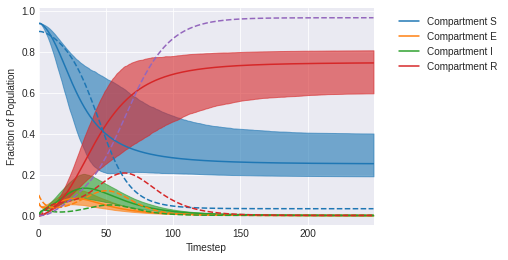

In [10]:
full_compartments = ['S'] + compartments
py0.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.plot(ref_traj[:,0], linestyle='--')
plt.show()


## Make restraints from reference trajectory


Using only first half of trajectory and use the R compartment in patch 0

In [11]:
npoints = 5
prior = maxent.Laplace(0.1)
# prior = maxent.EmptyPrior() # can try empty to compare with regressed
restraints, plot_fxns = py0.traj_to_restraints(ref_traj[:125,:,:], [0, -1], npoints, prior, noise=0.02)

17 0.045229007 0.04600261382679537
52 0.31069884 0.31863937795927444
31 0.11767925 0.11723202520565458
24 0.0786644 0.07803629805083809
101 0.8704176 0.8784110260147172


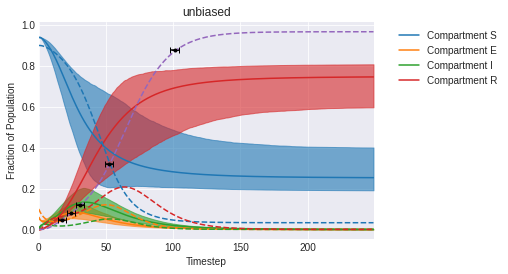

In [12]:
py0.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.title('unbiased')
plt.plot(ref_traj[:,0], linestyle='--')
for i,pf in enumerate(plot_fxns):
    pf(plt.gca(), 0)
plt.show()

In [13]:
me_model = maxent.MaxentModel(restraints)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')

In [14]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self. i = 0
    def on_epoch_begin(self, epoch, logs=None):
        self.i += 1
        return self.i

In [15]:
history = me_model.fit(trajs, batch_size=total_batches,epochs=100, callbacks=[CustomCallback()])

Epoch 1/100
1/1 [==============================] - 1s 572ms/step - loss: 0.8278 - weight-entropy: 8.4752
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.7954 - weight-entropy: 8.4991
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.7621 - weight-entropy: 8.5232
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.7279 - weight-entropy: 8.5475
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.6927 - weight-entropy: 8.5719
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: 0.6566 - weight-entropy: 8.5965
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.6195 - weight-entropy: 8.6212
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.5815 - weight-entropy: 8.6460
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.5427 - weight-entropy: 8.6707
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss:

1/1 [==============================] - 0s 2ms/step - loss: 0.0948 - weight-entropy: 8.9683
Epoch 80/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0943 - weight-entropy: 8.9694
Epoch 81/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0938 - weight-entropy: 8.9704
Epoch 82/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0933 - weight-entropy: 8.9714
Epoch 83/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0928 - weight-entropy: 8.9724
Epoch 84/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0923 - weight-entropy: 8.9733
Epoch 85/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0918 - weight-entropy: 8.9741
Epoch 86/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0913 - weight-entropy: 8.9749
Epoch 87/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0908 - weight-entropy: 8.9757
Epoch 88/100
1/1 [==============================] - 0s 2ms/step - loss: 0.090

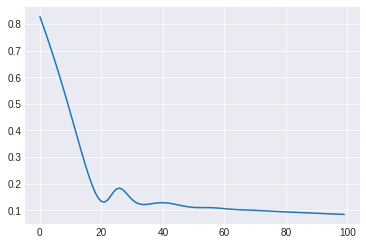

In [16]:
plt.plot(history.history['loss'])

## Using Algorithm 2

In [17]:
fit_param_model = py0.MetaParameterJoint(np.zeros((M,)), R, tmat, name='unbiased_model', n_infectious_compartments=1)
fit_param_model.compile(tf.optimizers.Adam(0.01))
# fit_param_model.compile(tf.optimizers.SGD(0.1))
hme_model = maxent.HyperMaxentModel(restraints, fit_param_model, model)
# hme_model.compile(tf.keras.optimizers.SGD(learning_rate=0.1), 'mean_squared_error')
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-3), 'mean_squared_error')                                                                          

In [18]:
history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=3, batch_size=N*batches, epochs=16)

Epoch 1/16
1/1 [==============================] - 0s 441ms/step - loss: 2.4828 - weight-entropy: 5.7617
Epoch 2/16
1/1 [==============================] - 0s 2ms/step - loss: 2.4817 - weight-entropy: 5.7626
Epoch 3/16
1/1 [==============================] - 0s 2ms/step - loss: 2.4806 - weight-entropy: 5.7635
Epoch 4/16
1/1 [==============================] - 0s 2ms/step - loss: 2.4795 - weight-entropy: 5.7644
Epoch 5/16
1/1 [==============================] - 0s 1ms/step - loss: 2.4784 - weight-entropy: 5.7654
Epoch 6/16
1/1 [==============================] - 0s 1ms/step - loss: 2.4773 - weight-entropy: 5.7663
Epoch 7/16
1/1 [==============================] - 0s 2ms/step - loss: 2.4762 - weight-entropy: 5.7672
Epoch 8/16
1/1 [==============================] - 0s 2ms/step - loss: 2.4751 - weight-entropy: 5.7681
Epoch 9/16
1/1 [==============================] - 0s 2ms/step - loss: 2.4740 - weight-entropy: 5.7690
Epoch 10/16
1/1 [==============================] - 0s 1ms/step - loss: 2.4728 - 

16/16 [==============================] - 0s 2ms/step - loss: -0.1207 - R-dist-dist_loss: -0.0058 - T-dist-dist_loss: -0.0041 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1081
Epoch 9/16
16/16 [==============================] - 0s 2ms/step - loss: -0.1207 - R-dist-dist_loss: -0.0058 - T-dist-dist_loss: -0.0041 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1080
Epoch 10/16
16/16 [==============================] - 0s 2ms/step - loss: -0.1207 - R-dist-dist_loss: -0.0058 - T-dist-dist_loss: -0.0041 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1080
Epoch 11/16
16/16 [==============================] - 0s 2ms/step - loss: -0.1207 - R-dist-dist_loss: -0.0058 - T-dist-dist_loss: -0.0041 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1081
Epoch 12/16
16/16 [==============================] - 0s 2ms/step - loss: -0.1207 - R-dist-dist_loss: -0.0058 - T-dist-dist_loss: -0.0041 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1081
Epoch 13/16
16/16 [=============================

In [19]:
history.history.keys()

dict_keys(['loss', 'weight-entropy', 'prior-loss', 'prior-R-dist-dist_loss', 'prior-T-dist-dist_loss', 'prior-rho-dist-dist_loss', 'prior-beta-dist_loss'])

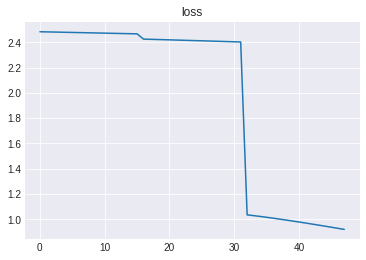

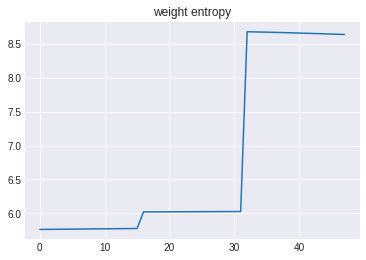

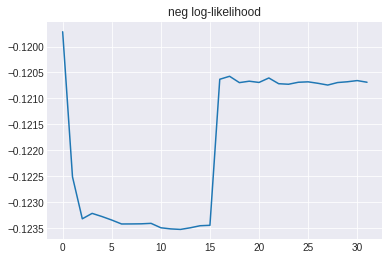

In [20]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.show()

plt.plot(history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

plt.plot(history.history['prior-loss'])
plt.title('neg log-likelihood')
plt.show()

In [21]:
fit_param_model.get_layer('beta').trainable_variables,param_model.get_layer('beta').trainable_variables

([<tf.Variable 'beta/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-2.060058]], dtype=float32)>],
 [<tf.Variable 'beta/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-2.3025851]], dtype=float32)>])

In [22]:
fit_param_model.summary()

Model: "unbiased_model-model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
R-dist-hypers (TrainableInputLa (None, 2, 4, 4)      32          input_2[0][0]                    
__________________________________________________________________________________________________
R-dist-jitter (Lambda)          (None, 2, 4, 4)      0           R-dist-hypers[0][0]              
__________________________________________________________________________________________________
T-dist-hypers (TrainableInputLa (None, 2, 3, 3)      18          input_2[0][0]                    
_______________________________________________________________________________

In [23]:
fit_param_model.get_layer('rho-dist-start-logit-hypers').trainable_variables,param_model.get_layer('rho-dist-start-logit-hypers').trainable_variables

([<tf.Variable 'value:0' shape=(4,) dtype=float32, numpy=array([ 0.31273344, -0.27341205, -0.19700877, -0.07437012], dtype=float32)>],
 [<tf.Variable 'value:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>])

In [24]:
hme_fit = np.sum((hme_model.restraint_values * hme_model.traj_weights[:,np.newaxis]), axis=0)
me_fit =  np.sum((me_model.restraint_values * me_model.traj_weights[:,np.newaxis]), axis=0)
print(hme_fit, me_fit)
print(np.mean(hme_fit**2), np.mean(me_fit**2))

[0.8450659  0.8691233  1.2901952  1.1919472  0.03851952] [-0.05233087  0.04149969  0.27413365  0.18065318 -0.5502893 ]
0.91126746 0.083012775


In [25]:
eh = -np.sum(hme_model.traj_weights * np.log(hme_model.traj_weights))
e =  -np.sum(me_model.traj_weights * np.log(me_model.traj_weights))
print('Maxent', e, 'after tuning', eh)

Maxent 8.983906 after tuning 8.634972


## Direct Regression of Model

In [26]:
T = tmat.value
start = np.zeros((M, C))
start[0,0] = 0.5
infect = py0.ContactInfectionLayer(0.1, infections_compartments)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += r(traj[0])**2
    return s
rmodel = py0.TrainableMetaModel(start, R, T, infect, 250, agreement)

In [27]:
rmodel.compile(optimizer=tf.keras.optimizers.Adam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(100)
rtraj = rmodel.get_traj()

100/100 [==============================] - 7s 53ms/step - loss: 0.9188 - output_2_loss: 0.9188


## Now visualize results

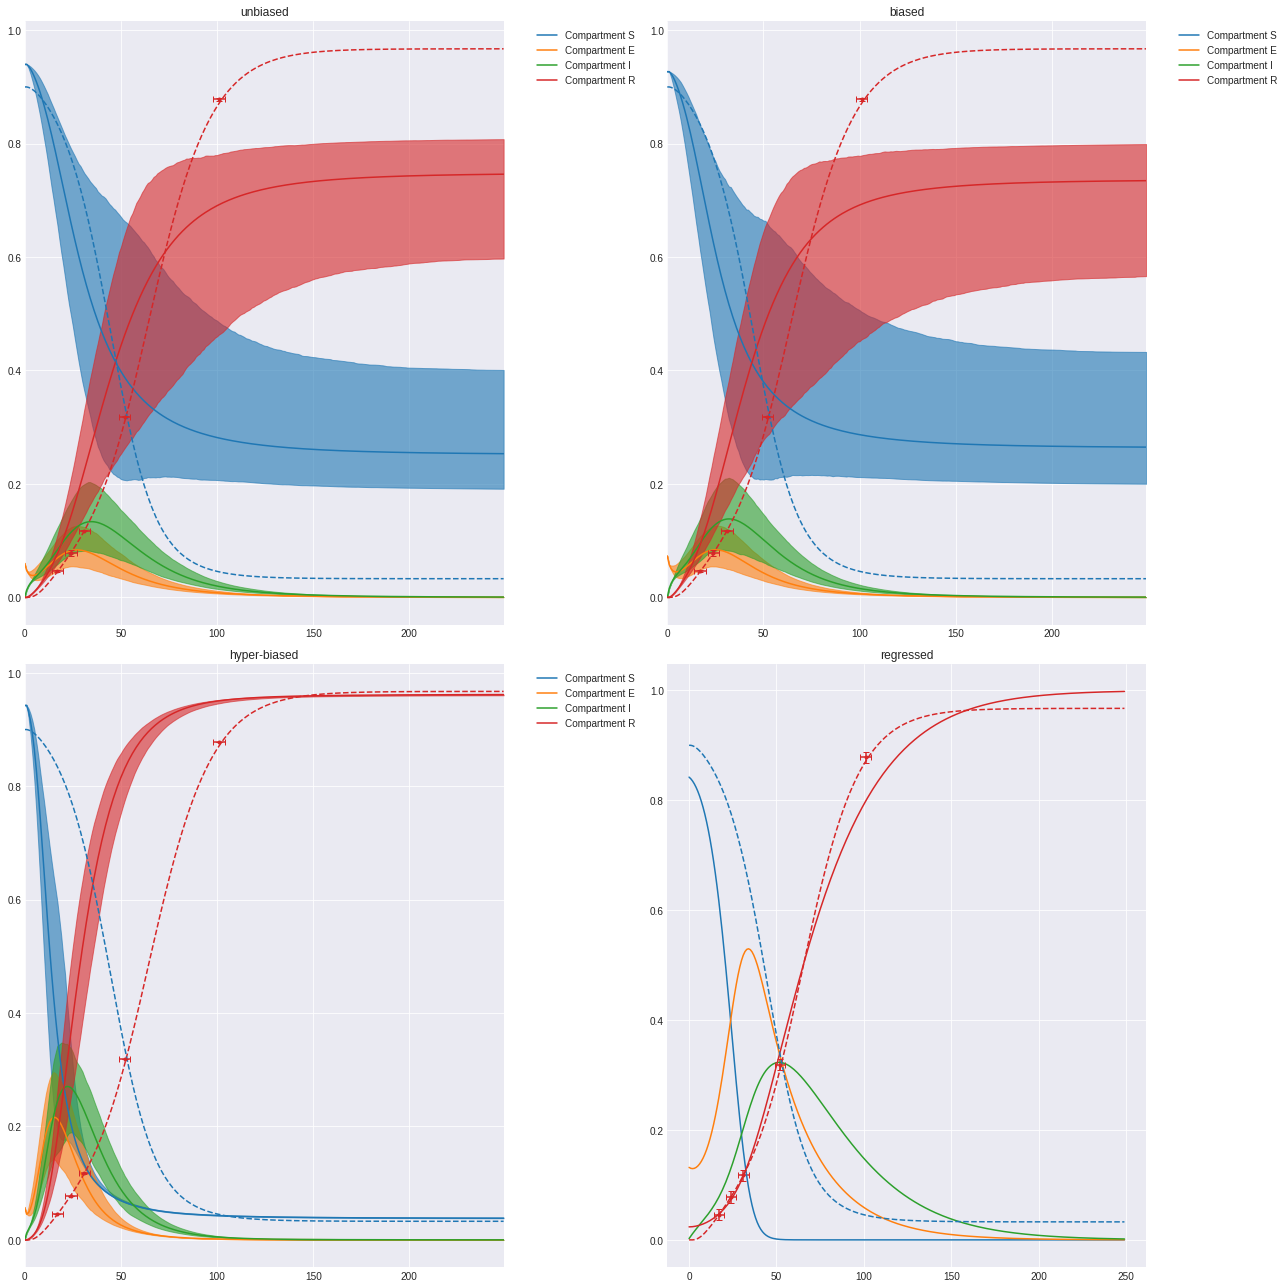

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
axs[0,0].set_title('unbiased')
py0.traj_quantile(trajs[:,:,0,:], names=full_compartments, ax=axs[0,0])
axs[0,0].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[0,0].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,0], me_model.lambdas[i], color='C3')

axs[0,1].set_title('biased')
py0.traj_quantile(trajs[:,:,0,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[0,1].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,1], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
py0.traj_quantile(hme_model.trajs[:,:,0,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[1,0].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,0,:])
axs[1,1].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[1,1].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,1], 1, color='C3')


## Other Patch

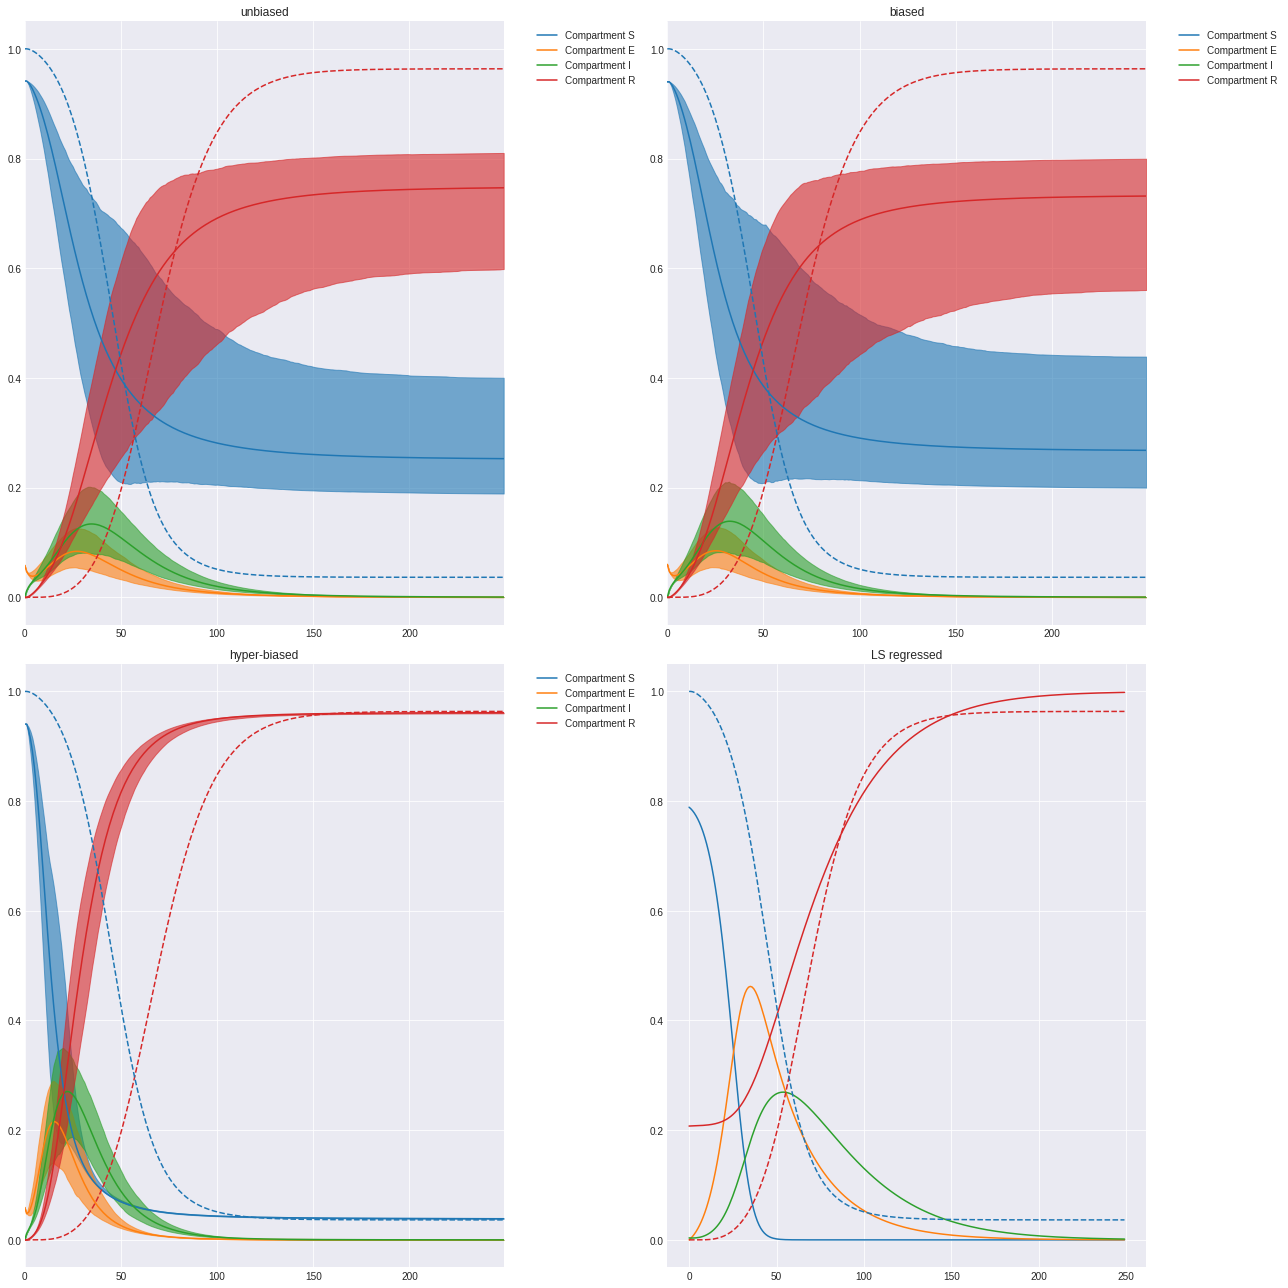

In [29]:
patch = 2
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
axs[0,0].set_title('unbiased')
py0.traj_quantile(trajs[:,:,patch,:], names=full_compartments, ax=axs[0,0])
axs[0,0].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[0,0].plot(ref_traj[:,patch,0], linestyle='--', color='C0')

axs[0,1].set_title('biased')
py0.traj_quantile(trajs[:,:,patch,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[0,1].plot(ref_traj[:,patch,0], linestyle='--', color='C0')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
py0.traj_quantile(hme_model.trajs[:,:,patch,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[1,0].plot(ref_traj[:,patch,0], linestyle='--', color='C0')
plt.tight_layout()

axs[1,1].set_title('LS regressed')
axs[1,1].plot(rtraj[0,:,patch,:])
axs[1,1].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[1,1].plot(ref_traj[:,patch,0], linestyle='--', color='C0')

plt.tight_layout()